<a href="https://colab.research.google.com/github/BianchiLuca28/FHNW-BI-LMS/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Overview
- Predictive model to determine "service_type" for shipments by a B2B company using third-party carriers.
- Dataset includes details like customer pricing, carrier pricing, shipment weights, and delivery locations.
- Objective: Predict service type using machine learning to support operational and strategic business decisions.

## Business Motivation
- **Operational Efficiency**: Optimize logistics and resource allocation.
- **Cost Savings**: Identify cost reduction opportunities.
- **Customer Experience**: Offer tailored services for different customer needs.
- **Strategic Insights**: Analyze profitability and trends across service types to enhance business planning.

## Data Analysis and Preprocessing
- **EDA**: Explored feature distributions, identified outliers, and evaluated class imbalances. This can found in the notebook *notebooks/EDA/eda_notebook.ipynb*.
- **Preprocessing**: Included feature selection, encoding, outlier removal, and margin estimation.

## Modeling Process
- **Handling Imbalanced Data**: Addressed class imbalances with SMOTE for underrepresented service types.
- **"Special" Class Reassessment**: Previously thought to have insufficient samples, further analysis revealed adequate representation in the dataset.
- This allowed inclusion of the "Special" class in the modeling process, with successful handling through SMOTE for training, which was one of the most important classes for the client.
- **Feature Selection** considering only the most important features and the ones that are available during the prediction.

## Model Selection and Evaluation
- **Algorithms**: Evaluated multiple models including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, XGBoost, and LightGBM.
- **Metrics**: Used metrics such as Accuracy, ROC AUC, and detailed classification reports.
- **Final Model**: Random Forest selected for its robust performance, achieving a Test Set Accuracy of 0.9758.

## Conclusion
- The model effectively predicts all service types.
- Provides actionable insights for operational decision-making and improving business efficiency.
- Enables the company to optimize its logistics, reduce costs, and enhance customer satisfaction.
- Having reached such high performance, it is clear that the dataset can indeed undercover some **important pattern** to predict the customer behavior.
- The cost matrix analysis revealed a total cost of 1120, primarily driven by false negatives (1100), reflecting the high impact of missing critical service type predictions. False positives contributed a smaller cost (20), aligning with the business priority of minimizing operational failures over minor inefficiencies. This highlights the importance of optimizing the model to reduce false negatives for greater business value.

# Module Setup

In [1]:
import os
import sys

# Check if running on Colab
if "google.colab" in sys.modules:
    print("Running on Colab. Downloading repository...")
    # Clone your repository on Colab
    if not os.path.exists("functions"):
        os.system("git clone https://github.com/BianchiLuca28/FHNW-BI-LMS.git")
        sys.path.append("/content/FHNW-BI-LMS")
else:
    print("Running locally. Adjusting import path...")
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

Running locally. Adjusting import path...


# Imports

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data preprocessing and utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)

# Oversampling
from imblearn.over_sampling import SMOTE

# Statistical tools
from scipy import stats

# Custom functions
from functions.functions import custom_train_test_split, encode_features

# Model and data saving
import pickle

# Importing dataset

Importing the dataset from the online source in Google Drive, or locally, depending where the notebook is executed.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Check if running on Colab
if "google.colab" in sys.modules:
    print("Running on Colab.")
    # Change with your location to read the dataset from
    folder_path = "/content/drive/MyDrive/__Shared/BI"
    df = pd.read_csv(folder_path + "/preprocessed_flattened_dataset.csv")
else:
    print("Running locally.")
    df = pd.read_csv("../../00-Project/datasets/preprocessed_flattened_dataset.csv")

Running locally.


/tmp/ipykernel_9018/3176858363.py:9: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../00-Project/datasets/preprocessed_flattened_dataset.csv")


# Preprocessing

In this phase, we treat everything we identified in the EDA phase.

## Removing unavailable columns at the moment of the prediction

These are the columns that aren't avaiable when making the prediction, so they represent something akin to "Target Leakage".

In [4]:
columns_to_exclude = [
    'year_delivery_date', 'month_delivery_date',
    'quarter_delivery_date', 'year_real_delivery_date',
    'month_real_delivery_date', 'quarter_real_delivery_date',
    'final_carrier_price',
    'margin',
    'year_pickup_date', 'month_pickup_date', 'quarter_pickup_date',
    'year_real_pickup_date', 'month_real_pickup_date', 'quarter_real_pickup_date',
    'domain_name_service',
    'domain_name_customer',
    'transport_type', 'shipment_id',
    'name_service',
    "customer_price",
    "expected_carrier_price",
    "name_carrier"
]

In [5]:
# Drop the identified columns to prevent label leakage
df = df.drop(columns=columns_to_exclude, axis=1)

## Handling missing values

To handle the missing values, we approached this problem in the following way:
- For the **service_type**, the rows that are missing the label, we just remove them.
- For the **numerical features**, we replaced them with the median, given the high number of outliers.
- For the **categorical features**, we replaced them with the value *missing*, which we intentionally wanted to introduce as a "new value" to represent the fact that the feature is missing.

In [6]:
# columns with NAs (with more than 0)
df.isna().sum()[df.isna().sum() > 0]

weight                              280
shipment_type                       280
insurance_type                      280
customer_id                         280
domain_name                         280
lms_plus                            280
exworks_id                       683441
main_industry_name_customer      222510
industry_sector_name_customer    222510
segmentation_customer            116856
sequence_number_customer            280
structure_number_customer           280
is_master_customer                  280
domain_name_delivery                280
postal_code_delivery              16080
city_delivery                       281
name_country_delivery             30872
iso_country_code_delivery         30894
continent_delivery                30872
EU_delivery                       30872
domain_name_pickup                  280
postal_code_pickup                 1569
city_pickup                         281
name_country_pickup                2328
iso_country_code_pickup            2328


In [7]:
# Drop columns with too many missing values (more than 70% missing)
threshold = len(df) * 0.7
df = df.dropna(axis=1, thresh=threshold)

# Remove rows where 'service_type' is NA
df = df.dropna(subset=['service_type'])

# Fill numeric columns with median and categorical columns with 'missing'
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna('missing')

/tmp/ipykernel_9018/1245711723.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_cols] = df[categorical_cols].fillna('missing')


## Feature Encoding

As mentioned before, we use the **One-Hot Encoding** for features with less than 10 classes, while we use the **Label Encoding** for the others that have a higher count.

In [8]:
# Split Features and Target
X = df.drop(["service_type"], axis=1)
y = df["service_type"]

In [9]:
# Encoding Strategy for Features
X = encode_features(X, cardinality_threshold=10)

## Train Test Split, SMOTE, and Scaling

Here we perform the *train_test_split* in a custom way.

In fact, in this phase, we:
1. Split the dataset in train and test (using 80% / 20% division), considering the **stratify** parameter to leave the same distributions of the target variable.
2. Apply SMOTE for the classes that have less than 2000 samples, in the *training dataset* (not in the test dataset), to make at least a bit more balanced the cases, multiplying their proportion by 10 times.
3. Scale the features using a **Standard Scaler**.


*Note*: We didn't remove the outliers, because after testing them, it seemed that the model performed worse, meaning that in this dataset, the outliers, actually had an important meaning.

In [10]:
X_train, X_test, y_train, y_test = custom_train_test_split(
    X, y, test_size=0.2, max_threshold=2000, multiplier=10, random_state=42
)

In [11]:
# Check the shapes
print(f"X_train: {X_train.shape}, y_train: {len(y_train)}")
print(f"X_test: {X_test.shape}, y_test: {len(y_test)}")

X_train: (581857, 55), y_train: 581857
X_test: (142236, 55), y_test: 142236


In [12]:
# Loop through all unique classes in y_train and y_test
for cls in set(y_train).union(set(y_test)):
    train_count = len(y_train[y_train == cls])
    test_count = len(y_test[y_test == cls])
    print(f"{cls} Class in y_train: {train_count}")
    print(f"{cls} Class in y_test: {test_count}")
    print("")

Import Class in y_train: 17001
Import Class in y_test: 4251

Express Class in y_train: 260609
Express Class in y_test: 65152

Special Class in y_train: 10380
Special Class in y_test: 260

Standard Class in y_train: 289897
Standard Class in y_test: 72474

Third_Country Class in y_train: 2670
Third_Country Class in y_test: 67

Sameday Class in y_train: 1300
Sameday Class in y_test: 32



## Feature selection

Using the feature importance from the Random Forest, we include in the dataset, only the 10 features with the highest importance.

Selected Features: ['weight', 'customer_id', 'segmentation_customer', 'sequence_number_customer', 'structure_number_customer', 'postal_code_delivery', 'city_delivery', 'name_country_delivery', 'iso_country_code_delivery', 'EU_delivery', 'postal_code_pickup', 'city_pickup', 'name_country_pickup', 'iso_country_code_pickup', 'EU_pickup', 'shipment_type_Parcel', 'continent_delivery_Europe', 'continent_pickup_Europe']


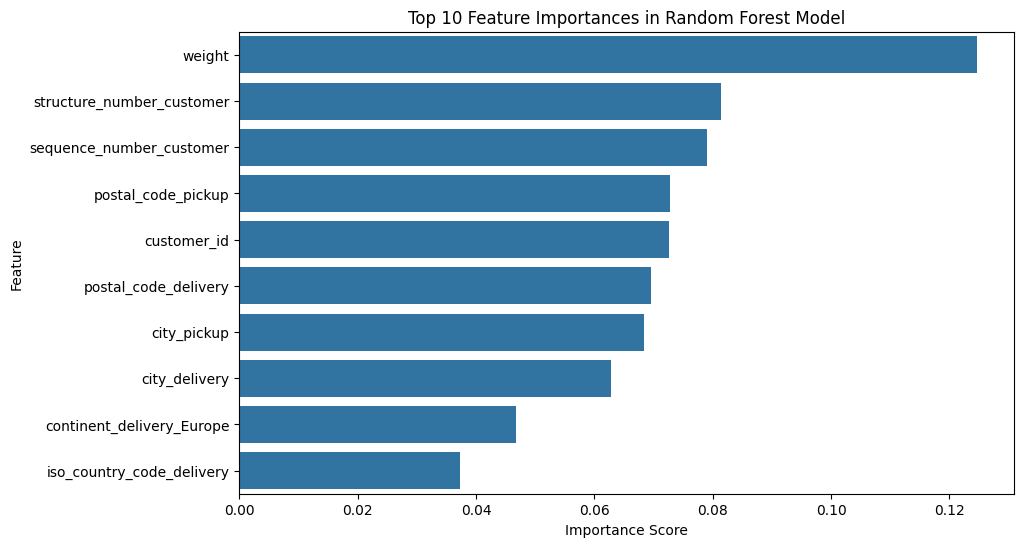

In [13]:
# Random Forest Feature Selection
# Train a RandomForestClassifier to determine feature importance
importance_rf = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduced number of estimators for simplicity
importance_rf.fit(X_train, y_train)

# Get Feature Importances and Select Important Features
feature_importances = pd.Series(importance_rf.feature_importances_, index=X_train.columns)
important_features = feature_importances[feature_importances > 0.01].index.tolist()  # Adjust threshold as needed

# Output the Selected Features
print("Selected Features:", important_features)

# Feature Importance Analysis (Top 10 from Selected Features)
selected_importances = feature_importances[important_features].sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_importances.values, y=selected_importances.index)
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [14]:
# Create Final Dataset with Selected Features
X_selected_train = X_train[important_features]
X_selected_test = X_test[important_features]

In [15]:
# Prepare training and test data
X_train, X_test = X_selected_train, X_selected_test

In [16]:
# Label encoding for target
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Model Training & Evaluation

Here we finally train and test different models to find the best ones.

We test the following models:
- Logistic Regression.
- Naive Bayes.
- Decision Tree.
- Random Forest.
- XGBoost.
- LightGBM.

Also, for each of the models:
1. We first apply the **K-Fold Cross Validation** (with k=5) to find the best model family.
2. We also train a model again for each of them, in order to compare different metrics for each of them when the model is trained on the whole training dataset.

The metrics used to do "Model Selection" (selecting the best model family) are:
- Cross Validation ROC-AUC.
- Test ROC-AUC.

In [17]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
}

In [18]:
# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Cross-validation with AUC as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='roc_auc_ovr')
    print(f"{model_name} Cross-Validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Train the model on the whole training dataset
    model.fit(X_train, y_train_encoded)

    # Test set predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Metrics
    roc_auc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class='ovr') if y_pred_prob is not None else None
    class_report = classification_report(y_test_encoded, y_pred, output_dict=True, zero_division=0)
    confusion = confusion_matrix(y_test_encoded, y_pred)

    # Store results
    results[model_name] = {
        "ROC AUC": roc_auc,
        "Cross-Validation AUC": cv_scores.mean(),
        "Cross-Validation Std Dev": cv_scores.std(),
        "Classification Report": class_report,
        "Confusion Matrix": confusion,
    }

    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"Test Set ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion)
    print("\n" + "=" * 60 + "\n")


Training Logistic Regression...
Logistic Regression Cross-Validation AUC: 0.8656 (+/- 0.0043)

Model: Logistic Regression
Test Set ROC AUC: 0.8238
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.54      0.63     65152
           1       0.48      0.74      0.58      4251
           2       0.00      0.62      0.00        32
           3       0.08      0.82      0.15       260
           4       0.71      0.68      0.69     72474
           5       0.01      0.54      0.01        67

    accuracy                           0.62    142236
   macro avg       0.34      0.66      0.35    142236
weighted avg       0.72      0.62      0.66    142236

Confusion Matrix:
[[35227  1462  3368  1008 20118  3969]
 [  242  3128   159    40   560   122]
 [    1     2    20     2     6     1]
 [    6     8    25   212     8     1]
 [11568  1905  6081  1241 49486  2193]
 [   11     7     4     0     9    36]]



Training Naive Bayes...
Naive 

In [19]:
# Display summary results focused on AUC
results_df = pd.DataFrame({
    model: {
        "Cross-Val AUC": metrics["Cross-Validation AUC"],
        "Test Set AUC": metrics["ROC AUC"],
    }
    for model, metrics in results.items()
}).T

print("Summary of Results:")
print(results_df)

Summary of Results:
                     Cross-Val AUC  Test Set AUC
Logistic Regression       0.865645      0.823845
Naive Bayes               0.831077      0.798006
Decision Tree             0.928322      0.887593
Random Forest             0.984537      0.958951
XGBoost                   0.977392      0.957206
LightGBM                  0.925196      0.852234


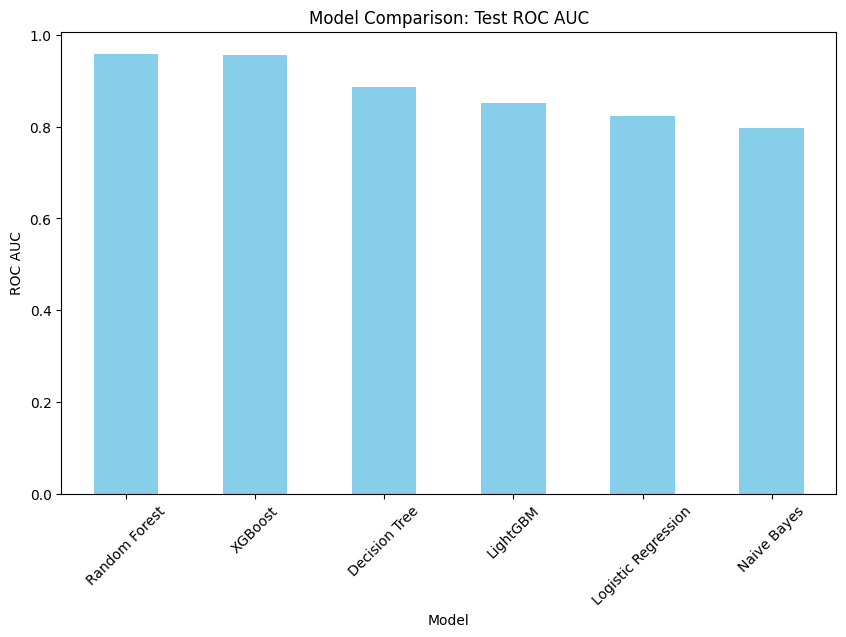

In [20]:
# Plot Test Accuracy for Comparison
plt.figure(figsize=(10, 6))
results_df["Test Set AUC"].sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Model Comparison: Test ROC AUC")
plt.ylabel("ROC AUC")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

It is clear that the best model, considering a robust metric such as the ROC-AUC, is the Random Forest.

# Analysis of Results

### Summary of Business Impact

The Random Forest model provides key insights for optimizing delivery services:
1. **Feature Importance**: The top features driving the predictions indicate which factors most impact the service type, providing insights into areas that can be optimized.
2. **Cost Matrix**: By analyzing the cost associated with false positives and false negatives, the model helps in understanding the financial implications of incorrect predictions. For example, reducing false positives might lower operational costs.
3. **Operational Efficiency**: By accurately predicting the service type, resources can be allocated more effectively, improving overall efficiency.
4. **Customer Targeting**: The insights from feature importance can help target specific customer segments with tailored services, increasing satisfaction and loyalty.

## Train best model

To do this:
1. Consideres the best model family resulting by comparing the previous "Cross Validation ROC-AUC", which is the Random Forest.
2. Trains a Random Search on a smaller sample, to find the best parameters (and to avoid taking days to complete).
3. Train with the full dataset a Random Search that uses those parameters.

In [21]:
# Randomly sample the dataset
sample_size = 0.1  # Use 10% of the dataset for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=sample_size, stratify=y_train, random_state=42)

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    "n_estimators": [300, 500, 700],  # Your original value and a slight increase
    "max_features": ["sqrt", 0.8],  # Default and a custom fraction
    "min_samples_split": [10, 15],  # Current value and a slightly higher one
    "min_samples_leaf": [2, 3],  # Current value and a slightly higher one
    "max_depth": [None, 30],  # Unlimited depth and a constrained option
    "class_weight": ["balanced"],  # Keep balanced for class imbalance
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc_ovr',  # Use AUC as the evaluation metric
    cv=3,                  # 3-fold cross-validation
    verbose=2,             # Print detailed output during the search
    n_jobs=-1              # Use all available cores for parallel processing
)

grid_search.fit(X_sample, y_sample)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")
print(f"Best Results: {grid_search.best_score_}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=300; total time=  59.0s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.0min
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.0min
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=300; total time= 1.0min
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=300; total time= 1.0min
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END class_weight=balanced, max_depth=None, max_features=s

/home/stas/.local/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time= 1.7min
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time= 1.7min
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time= 1.7min
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=  58.6s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time= 1.0min
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time= 1.0min
[CV] END class_weight=balanced, max_depth=None, max_features=0.8, min_samples_leaf=3, min_samples_split=15, n_estimators=700; total time

/home/stas/.local/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 700}
Best Results: 0.9677957410206289


In [22]:
# Train the final model on the full dataset using the best parameters
# final_rf = RandomForestClassifier(n_estimators=300,
#                                   random_state=42,
#                                   min_samples_split=10,
#                                   min_samples_leaf=2,
#                                   max_features='sqrt',
#                                   max_depth=None,
#                                   class_weight='balanced')

# Train the model on the parameters from the GridSearch
final_rf = RandomForestClassifier(**best_params, random_state=42)

final_rf.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred = final_rf.predict(X_test)
y_pred_prob = final_rf.predict_proba(X_test)

## Export the model and the training and test data

In [25]:
# Save the trained model
pickle.dump(final_rf, open('final_rf_model.pkl', 'wb'))

# Save the preprocessed training data
X_train.to_pickle('X_train.pkl')
np.save('y_train.npy', y_train)

## Compute metrics of performance

In [26]:
# Calculate performance metrics
class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
confusion = confusion_matrix(y_test, y_pred)

# Calculate ROC AUC for multiclass
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display ROC AUC
print(f"Test Set ROC AUC: {roc_auc:.4f}")

# Print classification report and confusion matrix for interpretability
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion)

Test Set ROC AUC: 0.9755
Classification Report:
               precision    recall  f1-score   support

      Express       0.91      0.85      0.88     65152
       Import       0.99      1.00      1.00      4251
      Sameday       0.39      0.47      0.43        32
      Special       0.82      0.86      0.84       260
     Standard       0.87      0.92      0.90     72474
Third_Country       0.98      0.84      0.90        67

     accuracy                           0.89    142236
    macro avg       0.83      0.82      0.82    142236
 weighted avg       0.89      0.89      0.89    142236

Confusion Matrix:
[[55620     1    11    17  9503     0]
 [    0  4245     0     1     4     1]
 [    3     1    15     1    12     0]
 [   12     6     1   224    17     0]
 [ 5713     4    11    29 66717     0]
 [    1    10     0     0     0    56]]


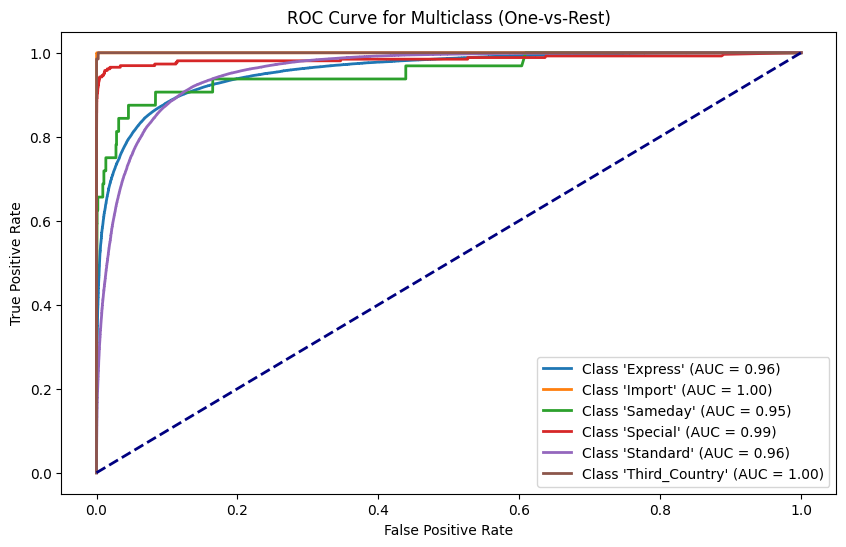

In [27]:
# Plot ROC Curve for each class using the original class labels
plt.figure(figsize=(10, 6))

# Get the unique class labels from y_test
unique_classes = sorted(pd.Series(y_test).unique())  # Ensure classes are sorted

for i, class_label in enumerate(unique_classes):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_pred_prob[:, i])
    class_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class '{class_label}' (AUC = {class_auc:.2f})")

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

## Cost Matrix

For this analysis, we assume the following:
- FN Cost: \$100 (missing a "Special" shipment is highly costly).
- FP Cost: \$10 (mislabeling a regular shipment as "Special" has moderate cost).
- TN/TP Cost: \$0 (correct predictions have no penalty).

The cost matrix emphasizes minimizing **false negatives** as missing a critical service type prediction can lead to significant operational or financial issues, while **false positives** cause minor inefficiencies. This approach aligns with business priorities to ensure service reliability.

In [28]:
# Updated Cost Matrix Analysis
cost_matrix = np.array([[0, 10],
                        [100, 0]])  # Costs: [[TN, FP], [FN, TP]]

# Calculate total cost from confusion matrix
cost = 0

for i in range(len(confusion)):
    for j in range(len(confusion)):
        cost += confusion[i, j] * cost_matrix[min(i, 1), min(j, 1)]  # Map confusion indices to cost matrix
print(f"Total Cost Based on Cost Matrix: {cost}")

Total Cost Based on Cost Matrix: 668220


In [29]:
# Cost Breakdown by Outcome
tn_cost = confusion[0, 0] * cost_matrix[0, 0]
fp_cost = confusion[0, 1] * cost_matrix[0, 1]
fn_cost = confusion[1, 0] * cost_matrix[1, 0]
tp_cost = confusion[1, 1] * cost_matrix[1, 1]

print(f"Cost Breakdown:")
print(f"True Negatives (TN): {tn_cost}")
print(f"False Positives (FP): {fp_cost}")
print(f"False Negatives (FN): {fn_cost}")
print(f"True Positives (TP): {tp_cost}")
print(f"Total Cost: {tn_cost + fp_cost + fn_cost + tp_cost}")

Cost Breakdown:
True Negatives (TN): 0
False Positives (FP): 10
False Negatives (FN): 0
True Positives (TP): 0
Total Cost: 10


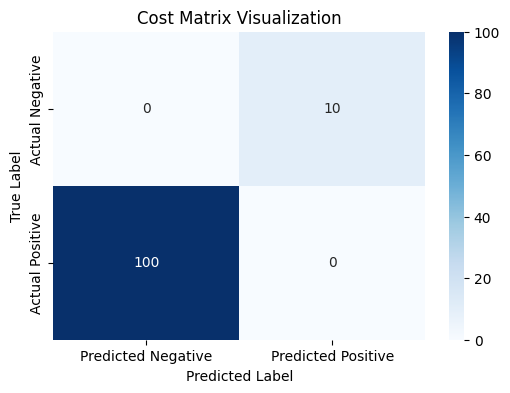

In [30]:
# Visualize the updated cost matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cost_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Cost Matrix Visualization')
plt.show()

## Feature importance

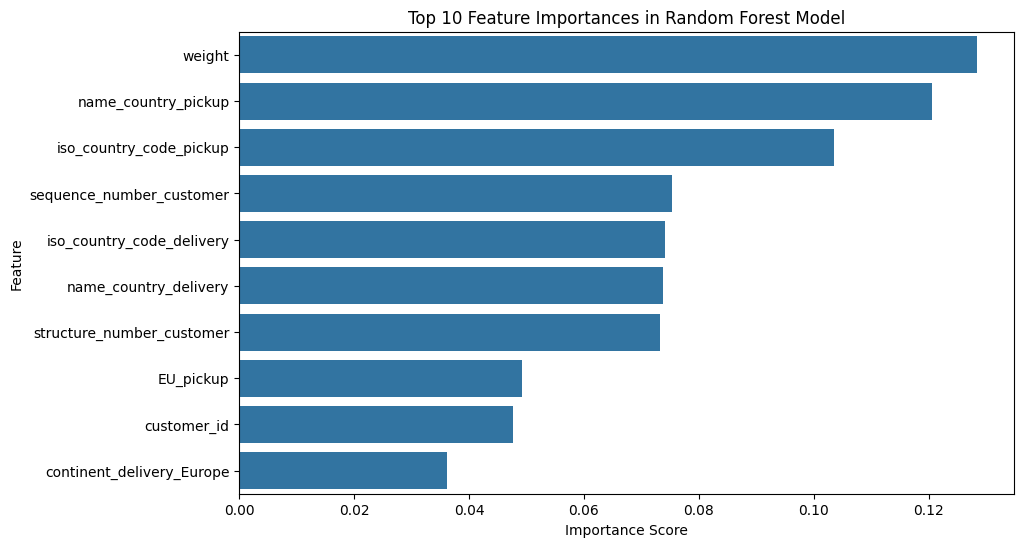

In [31]:
# Feature Importance Analysis
importances = pd.Series(final_rf.feature_importances_, index=X_selected_train.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Business Interpretation

In [32]:
print("\nBusiness Interpretation of Results:")
print(f"*** Emphasized Metric ***")
print(f"Test Set ROC AUC: {roc_auc:.4f}")

print("\nSupporting Metrics:")
print(f"Test Set Accuracy: {accuracy:.4f}")
print("Classification Report:")
for label, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"{label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}")


Business Interpretation of Results:
*** Emphasized Metric ***
Test Set ROC AUC: 0.9755

Supporting Metrics:
Test Set Accuracy: 0.8920
Classification Report:
Express: Precision=0.91, Recall=0.85, F1-score=0.88
Import: Precision=0.99, Recall=1.00, F1-score=1.00
Sameday: Precision=0.39, Recall=0.47, F1-score=0.43
Special: Precision=0.82, Recall=0.86, F1-score=0.84
Standard: Precision=0.87, Recall=0.92, F1-score=0.90
Third_Country: Precision=0.98, Recall=0.84, F1-score=0.90
macro avg: Precision=0.83, Recall=0.82, F1-score=0.82
weighted avg: Precision=0.89, Recall=0.89, F1-score=0.89


For the model analysis, we also have these recommendations:

- Geographic Service Optimization: Location drives over 61% of routing decisions, with continental boundaries and EU status being critical differentiators. Recommendation is to tailor service offerings by geographic region and optimize carrier partnerships accordingly.

- Customer Segmentation Strategy: Customer structure information and sequence patterns significantly influence service allocation, with distinct preferences across segments. Recommendation is to develop targeted service packages based on customer characteristics.

- Service Portfolio Focus: Express and Standard services account for 96.2% of all decisions, while specialized services serve specific customer-location combinations. Recommendation is to optimize core services while maintaining specialized offerings for specific market needs.